<a href="https://colab.research.google.com/github/Koks-creator/PytorchCatsVsDogsCNN/blob/main/PytorchCatsVsDogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Set environment to GPU**

In [1]:
from typing import Tuple, Union
from time import perf_counter
import glob
import os
from google.colab import files
from zipfile import ZipFile
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image

In [2]:
uploaded = files.upload()

!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [3]:
!kaggle datasets download -d tongpython/cat-and-dog

100% 217M/218M [00:10<00:00, 24.8MB/s]
100% 218M/218M [00:10<00:00, 21.4MB/s]


In [4]:
TRAIN_PATH = "training_set/training_set"
TEST_PATH = "test_set/test_set"
TRAIN_CSV_PATH = "/content/train_data.csv"
TEST_CSV_PATH = "/content/test_data.csv"
MODEL_PATH = "catvsdog.pt"
ZIP_FILE_PATH = "/content/cat-and-dog.zip"
CLASSES = ["cat", "dog"]

# Hyper params
NUM_EPOCHS = 50
BATCH_SIZE = 32
LEARNING_RATE = 0.001

In [5]:
with ZipFile(ZIP_FILE_PATH, 'r') as zipf:
    zipf.extractall()
    print("Done")

Done


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

**Prepare dataset**

In [7]:
def prepare_dataset_file(data_path: str, save: Union[str, bool]=False, limit_per_class: Union[str, bool]=False) -> pd.DataFrame:
    filenames = []
    paths = []
    classes_indexes = []

    for index, class_name in enumerate(os.listdir(data_path)):
        class_images = glob.glob(rf"{data_path}/{class_name}/*.jpg")
        if limit_per_class:
            class_images = class_images[:limit_per_class]

        print(f"Addiing: {class_name}")
        for image_path in tqdm(class_images):
            filename = os.path.split(image_path)[1]

            filenames.append(filename)
            paths.append(image_path)
            classes_indexes.append(index)

    df =  pd.DataFrame(
      {
          "Filename": filenames,
          "Path": paths,
          "ClassIndex": classes_indexes
      })

    if save:
      df.to_csv(save)

    return df

In [8]:
train_df = prepare_dataset_file(TRAIN_PATH, TRAIN_CSV_PATH, limit_per_class=False)
test_df = prepare_dataset_file(TEST_PATH, TEST_CSV_PATH, limit_per_class=False)

Addiing: cats


100%|██████████| 4000/4000 [00:00<00:00, 454445.42it/s]


Addiing: dogs


100%|██████████| 4005/4005 [00:00<00:00, 342400.89it/s]


Addiing: cats


100%|██████████| 1011/1011 [00:00<00:00, 289272.21it/s]


Addiing: dogs


100%|██████████| 1012/1012 [00:00<00:00, 281045.86it/s]


In [9]:
class ImageDataset(Dataset):
    def __init__(self, root_data_path: str, delimiter=",", transform=None) -> None:
        self.root_data_path = root_data_path
        self.transform = transform
        self.delimiter = delimiter

        self.df = pd.read_csv(root_data_path, delimiter=delimiter)

    # support indexing such that dataset[i] can be used to get i-th sample
    def __getitem__(self, index) -> Tuple[torch.Tensor, torch.Tensor]:
        row = self.df.loc[index]

        class_index = row.ClassIndex
        image_path = row.Path

        img = cv2.imread(image_path)
        if self.transform:
            img = self.transform(img)

        return img, torch.from_numpy(np.array(class_index, dtype=np.int64))

    def __len__(self) -> int:
        return len(self.df)


In [10]:
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224), antialias=True),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [11]:
train_dataset = ImageDataset(TRAIN_CSV_PATH, transform=data_transforms)
test_dataset = ImageDataset(TEST_CSV_PATH, transform=data_transforms)

In [12]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=2)

test_loader = DataLoader(dataset=test_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=2)

In [13]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

In [14]:
images.shape

torch.Size([32, 3, 224, 224])

In [15]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

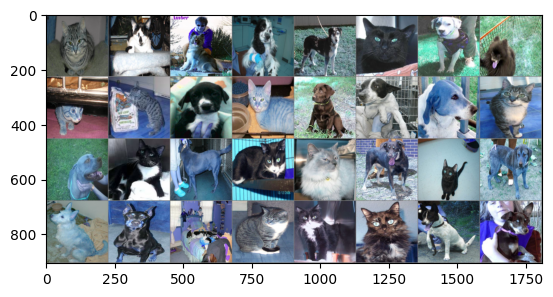

In [16]:
imshow(torchvision.utils.make_grid(images))

**Create Model**

In [17]:
conv0 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3,3), stride=(1,1), padding=(1,1), bias=False)
bn0 = nn.BatchNorm2d(num_features=16)
maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))

conv1 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3), stride=(1,1), padding=(1,1), bias=False)
bn1 = nn.BatchNorm2d(num_features=32)

conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), stride=(1,1), padding=(1,1), bias=False)
bn2 = nn.BatchNorm2d(num_features=64)

conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), stride=(1,1), padding=(1,1), bias=False)
bn3 = nn.BatchNorm2d(num_features=128)

dropout = nn.Dropout(p=0.5)
fc0 = nn.Linear(in_features=128*14*14, out_features=64)
fc1 = nn.Linear(in_features=64, out_features=32)
fc2 = nn.Linear(in_features=32, out_features=1)

In [18]:
x = F.relu(bn0(conv0(images)))
x = maxpool(x)
print(x.shape)

x = F.relu(bn1(conv1(x)))
x = maxpool(x)
print(x.shape)

x = F.relu(bn2(conv2(x)))
x = maxpool(x)
print(x.shape)

x = F.relu(bn3(conv3(x)))
x = maxpool(x)
print(x.shape)  # this shape is important since it has to match in_features of fc0

x = x.reshape(x.shape[0], -1)
print(x.shape)

x = dropout(x)
print(x.shape)
x = F.relu(fc0(x))
x = F.relu(fc1(x))
x = F.sigmoid(fc2(x))


torch.Size([32, 16, 112, 112])
torch.Size([32, 32, 56, 56])
torch.Size([32, 64, 28, 28])
torch.Size([32, 128, 14, 14])
torch.Size([32, 25088])
torch.Size([32, 25088])


In [19]:
class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv0 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3,3), stride=(1,1), padding=(1,1), bias=False)
        self.bn0 = nn.BatchNorm2d(num_features=16)
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))

        self.conv1 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3), stride=(1,1), padding=(1,1), bias=False)
        self.bn1 = nn.BatchNorm2d(num_features=32)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), stride=(1,1), padding=(1,1), bias=False)
        self.bn2 = nn.BatchNorm2d(num_features=64)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), stride=(1,1), padding=(1,1), bias=False)
        self.bn3 = nn.BatchNorm2d(num_features=128)

        self.dropout = nn.Dropout(p=0.5)
        self.fc0 = nn.Linear(in_features=128*14*14, out_features=64)
        self.fc1 = nn.Linear(in_features=64, out_features=32)
        self.fc2 = nn.Linear(in_features=32, out_features=1)

    def forward(self, x):
        x = F.relu(self.bn0(self.conv0(x)))
        x = self.maxpool(x)

        x = F.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        x = F.relu(self.bn2(self.conv2(x)))
        x = self.maxpool(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = self.maxpool(x)

        x = x.reshape(x.shape[0], -1)

        x = self.dropout(x)
        x = F.relu(self.fc0(x))
        x = F.relu(self.fc1(x))
        x = F.sigmoid(self.fc2(x))

        return x

**Training**

In [20]:
def get_test_accuracy(data_loader: DataLoader, model, loss_function) -> Tuple[float, float]:
    n_correct = 0
    n_samples = 0
    test_loss = 0

    model.eval()

    with torch.no_grad():
        for images, labels in train_loader:
            images = images.float().to(device)
            labels = labels.float().to(device)

            outputs = model(images)
            test_loss  = loss_function(outputs, labels.unsqueeze(1))

            predicted = outputs.round()

            n_samples += labels.size(0)
            n_correct += (predicted.squeeze() == labels).sum().item()

    model.train()
    return 100 * n_correct/n_samples, test_loss

In [21]:
model = CNNModel().to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

n_total_steps = len(train_loader)

In [22]:
len(train_loader)

251

In [23]:
train_loss_history = []
test_loss_history = []
train_accuracy_history = []
test_accuracy_history = []

for epoch in range(NUM_EPOCHS):
    epoch_train_loss_values = []
    epoch_test_loss_values = []
    epoch_train_accuracy_values = []
    epoch_test_accuracy_values = []


    num_correct_train = 0
    num_samples_train = 0
    print(f"------------------- EPOCH {epoch+1}/{NUM_EPOCHS} -------------------")
    for index, (train_images, train_labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        train_images = train_images.float().to(device)
        train_labels = train_labels.float().to(device)

        # forward pass
        outputs = model(train_images)
        loss = criterion(outputs, train_labels.unsqueeze(1))

        # Calculate train accuracy
        with torch.no_grad():
            rounded_train_preds = torch.round(outputs)
            num_correct_train += torch.sum(rounded_train_preds.squeeze() == train_labels)
            num_samples_train += len(train_labels)

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss_history.append(epoch_train_loss_values)
    test_loss_history.append(epoch_test_loss_values)
    train_accuracy_history.append(epoch_train_accuracy_values)
    test_accuracy_history.append(epoch_test_accuracy_values)


    # Display epoch summary
    train_acc = 100 * num_correct_train / num_samples_train
    test_acc, test_loss = get_test_accuracy(train_loader, model, criterion)

    print(f'\nEpoch [{epoch+1}/{NUM_EPOCHS}] Step [{index+1}/{n_total_steps}] Loss: {loss.item():.4f}, Test loss: {test_loss:.4f} | Acc: {train_acc:.4f}, Test acc: {test_acc:.4f}')

    epoch_train_loss_values.append(loss.item())
    epoch_test_loss_values.append(test_loss.item())
    epoch_train_accuracy_values.append(train_acc.item())
    epoch_test_accuracy_values.append(test_acc)


print("Training finished")

------------------- EPOCH 1/50 -------------------


100%|██████████| 251/251 [00:46<00:00,  5.35it/s]



Epoch [1/50] Step [251/251] Loss: 0.8158, Test loss: 0.5621 | Acc: 66.7083, Test acc: 74.8282
------------------- EPOCH 2/50 -------------------


100%|██████████| 251/251 [00:37<00:00,  6.66it/s]



Epoch [2/50] Step [251/251] Loss: 0.5544, Test loss: 0.6527 | Acc: 75.2904, Test acc: 75.9026
------------------- EPOCH 3/50 -------------------


100%|██████████| 251/251 [00:37<00:00,  6.76it/s]



Epoch [3/50] Step [251/251] Loss: 0.2723, Test loss: 0.5889 | Acc: 78.0512, Test acc: 80.9494
------------------- EPOCH 4/50 -------------------


100%|██████████| 251/251 [00:37<00:00,  6.65it/s]



Epoch [4/50] Step [251/251] Loss: 0.6142, Test loss: 0.3604 | Acc: 80.3997, Test acc: 82.3735
------------------- EPOCH 5/50 -------------------


100%|██████████| 251/251 [00:37<00:00,  6.65it/s]



Epoch [5/50] Step [251/251] Loss: 0.3150, Test loss: 1.4469 | Acc: 82.5734, Test acc: 73.5290
------------------- EPOCH 6/50 -------------------


100%|██████████| 251/251 [00:37<00:00,  6.67it/s]



Epoch [6/50] Step [251/251] Loss: 0.3743, Test loss: 0.1862 | Acc: 84.9594, Test acc: 83.9975
------------------- EPOCH 7/50 -------------------


100%|██████████| 251/251 [00:36<00:00,  6.80it/s]



Epoch [7/50] Step [251/251] Loss: 0.3165, Test loss: 0.3331 | Acc: 86.0087, Test acc: 89.6565
------------------- EPOCH 8/50 -------------------


100%|██████████| 251/251 [00:38<00:00,  6.58it/s]



Epoch [8/50] Step [251/251] Loss: 0.1065, Test loss: 0.1116 | Acc: 87.8451, Test acc: 88.3823
------------------- EPOCH 9/50 -------------------


100%|██████████| 251/251 [00:38<00:00,  6.56it/s]



Epoch [9/50] Step [251/251] Loss: 0.1499, Test loss: 0.2667 | Acc: 89.4566, Test acc: 91.7427
------------------- EPOCH 10/50 -------------------


100%|██████████| 251/251 [00:37<00:00,  6.64it/s]



Epoch [10/50] Step [251/251] Loss: 0.5446, Test loss: 0.0512 | Acc: 90.1062, Test acc: 93.2917
------------------- EPOCH 11/50 -------------------


100%|██████████| 251/251 [00:37<00:00,  6.70it/s]



Epoch [11/50] Step [251/251] Loss: 0.1438, Test loss: 0.7404 | Acc: 90.8807, Test acc: 93.8538
------------------- EPOCH 12/50 -------------------


100%|██████████| 251/251 [00:38<00:00,  6.60it/s]



Epoch [12/50] Step [251/251] Loss: 0.0635, Test loss: 0.0450 | Acc: 91.7926, Test acc: 94.0287
------------------- EPOCH 13/50 -------------------


100%|██████████| 251/251 [00:38<00:00,  6.60it/s]



Epoch [13/50] Step [251/251] Loss: 0.0099, Test loss: 0.2225 | Acc: 92.8670, Test acc: 91.8051
------------------- EPOCH 14/50 -------------------


100%|██████████| 251/251 [00:38<00:00,  6.47it/s]



Epoch [14/50] Step [251/251] Loss: 0.6698, Test loss: 0.0683 | Acc: 93.5665, Test acc: 92.2049
------------------- EPOCH 15/50 -------------------


100%|██████████| 251/251 [00:37<00:00,  6.61it/s]



Epoch [15/50] Step [251/251] Loss: 0.0605, Test loss: 0.0272 | Acc: 94.1412, Test acc: 96.4147
------------------- EPOCH 16/50 -------------------


100%|██████████| 251/251 [00:37<00:00,  6.66it/s]



Epoch [16/50] Step [251/251] Loss: 0.0669, Test loss: 0.2203 | Acc: 95.1530, Test acc: 88.6321
------------------- EPOCH 17/50 -------------------


100%|██████████| 251/251 [00:38<00:00,  6.56it/s]



Epoch [17/50] Step [251/251] Loss: 0.0510, Test loss: 0.0204 | Acc: 95.3904, Test acc: 97.6265
------------------- EPOCH 18/50 -------------------


100%|██████████| 251/251 [00:39<00:00,  6.37it/s]



Epoch [18/50] Step [251/251] Loss: 0.0032, Test loss: 0.0318 | Acc: 95.5153, Test acc: 95.6902
------------------- EPOCH 19/50 -------------------


100%|██████████| 251/251 [00:38<00:00,  6.55it/s]



Epoch [19/50] Step [251/251] Loss: 0.3049, Test loss: 0.1134 | Acc: 96.4772, Test acc: 97.5390
------------------- EPOCH 20/50 -------------------


100%|██████████| 251/251 [00:38<00:00,  6.55it/s]



Epoch [20/50] Step [251/251] Loss: 1.2309, Test loss: 0.0588 | Acc: 95.6652, Test acc: 97.4641
------------------- EPOCH 21/50 -------------------


100%|██████████| 251/251 [00:38<00:00,  6.60it/s]



Epoch [21/50] Step [251/251] Loss: 0.0001, Test loss: 0.0083 | Acc: 97.0144, Test acc: 98.9881
------------------- EPOCH 22/50 -------------------


100%|██████████| 251/251 [00:37<00:00,  6.77it/s]



Epoch [22/50] Step [251/251] Loss: 0.4695, Test loss: 0.0010 | Acc: 97.2517, Test acc: 98.8882
------------------- EPOCH 23/50 -------------------


100%|██████████| 251/251 [00:37<00:00,  6.63it/s]



Epoch [23/50] Step [251/251] Loss: 0.1070, Test loss: 0.2458 | Acc: 96.9644, Test acc: 99.2755
------------------- EPOCH 24/50 -------------------


100%|██████████| 251/251 [00:38<00:00,  6.54it/s]



Epoch [24/50] Step [251/251] Loss: 0.0005, Test loss: 0.1495 | Acc: 97.5141, Test acc: 94.2036
------------------- EPOCH 25/50 -------------------


100%|██████████| 251/251 [00:38<00:00,  6.53it/s]



Epoch [25/50] Step [251/251] Loss: 0.0084, Test loss: 0.0024 | Acc: 97.5640, Test acc: 99.2255
------------------- EPOCH 26/50 -------------------


100%|██████████| 251/251 [00:38<00:00,  6.57it/s]



Epoch [26/50] Step [251/251] Loss: 0.0834, Test loss: 0.0016 | Acc: 97.7139, Test acc: 99.4628
------------------- EPOCH 27/50 -------------------


100%|██████████| 251/251 [00:38<00:00,  6.58it/s]



Epoch [27/50] Step [251/251] Loss: 0.7727, Test loss: 0.0015 | Acc: 98.0012, Test acc: 99.3004
------------------- EPOCH 28/50 -------------------


100%|██████████| 251/251 [00:38<00:00,  6.56it/s]



Epoch [28/50] Step [251/251] Loss: 0.0028, Test loss: 0.0035 | Acc: 98.0512, Test acc: 99.1006
------------------- EPOCH 29/50 -------------------


100%|██████████| 251/251 [00:38<00:00,  6.55it/s]



Epoch [29/50] Step [251/251] Loss: 0.0008, Test loss: 0.0003 | Acc: 98.1636, Test acc: 98.4385
------------------- EPOCH 30/50 -------------------


100%|██████████| 251/251 [00:38<00:00,  6.59it/s]



Epoch [30/50] Step [251/251] Loss: 0.0042, Test loss: 0.0001 | Acc: 98.2886, Test acc: 99.4753
------------------- EPOCH 31/50 -------------------


100%|██████████| 251/251 [00:37<00:00,  6.72it/s]



Epoch [31/50] Step [251/251] Loss: 0.0001, Test loss: 0.0002 | Acc: 97.9388, Test acc: 99.6127
------------------- EPOCH 32/50 -------------------


100%|██████████| 251/251 [00:38<00:00,  6.55it/s]



Epoch [32/50] Step [251/251] Loss: 0.0029, Test loss: 0.0038 | Acc: 98.3635, Test acc: 99.6877
------------------- EPOCH 33/50 -------------------


100%|██████████| 251/251 [00:38<00:00,  6.57it/s]



Epoch [33/50] Step [251/251] Loss: 0.0000, Test loss: 0.0166 | Acc: 98.4760, Test acc: 97.7889
------------------- EPOCH 34/50 -------------------


100%|██████████| 251/251 [00:38<00:00,  6.60it/s]



Epoch [34/50] Step [251/251] Loss: 0.0004, Test loss: 0.0002 | Acc: 98.4760, Test acc: 99.7626
------------------- EPOCH 35/50 -------------------


100%|██████████| 251/251 [00:37<00:00,  6.66it/s]



Epoch [35/50] Step [251/251] Loss: 0.0717, Test loss: 0.0002 | Acc: 98.1636, Test acc: 99.8376
------------------- EPOCH 36/50 -------------------


100%|██████████| 251/251 [00:37<00:00,  6.63it/s]



Epoch [36/50] Step [251/251] Loss: 0.0001, Test loss: 0.0045 | Acc: 98.7133, Test acc: 99.7876
------------------- EPOCH 37/50 -------------------


100%|██████████| 251/251 [00:38<00:00,  6.58it/s]



Epoch [37/50] Step [251/251] Loss: 0.0305, Test loss: 0.1632 | Acc: 98.6633, Test acc: 99.6502
------------------- EPOCH 38/50 -------------------


100%|██████████| 251/251 [00:38<00:00,  6.54it/s]



Epoch [38/50] Step [251/251] Loss: 0.0021, Test loss: 0.0048 | Acc: 98.5259, Test acc: 97.1893
------------------- EPOCH 39/50 -------------------


100%|██████████| 251/251 [00:38<00:00,  6.57it/s]



Epoch [39/50] Step [251/251] Loss: 0.0002, Test loss: 0.0104 | Acc: 99.0881, Test acc: 99.8626
------------------- EPOCH 40/50 -------------------


100%|██████████| 251/251 [00:37<00:00,  6.69it/s]



Epoch [40/50] Step [251/251] Loss: 0.0185, Test loss: 0.0003 | Acc: 99.0131, Test acc: 99.7252
------------------- EPOCH 41/50 -------------------


100%|██████████| 251/251 [00:38<00:00,  6.58it/s]



Epoch [41/50] Step [251/251] Loss: 0.0005, Test loss: 0.0107 | Acc: 98.5509, Test acc: 99.6877
------------------- EPOCH 42/50 -------------------


100%|██████████| 251/251 [00:37<00:00,  6.62it/s]



Epoch [42/50] Step [251/251] Loss: 0.0001, Test loss: 0.0000 | Acc: 98.8007, Test acc: 99.7502
------------------- EPOCH 43/50 -------------------


100%|██████████| 251/251 [00:39<00:00,  6.42it/s]



Epoch [43/50] Step [251/251] Loss: 0.0044, Test loss: 0.0107 | Acc: 99.0631, Test acc: 99.6002
------------------- EPOCH 44/50 -------------------


100%|██████████| 251/251 [00:38<00:00,  6.60it/s]



Epoch [44/50] Step [251/251] Loss: 0.0033, Test loss: 0.0001 | Acc: 98.8007, Test acc: 99.8876
------------------- EPOCH 45/50 -------------------


100%|██████████| 251/251 [00:37<00:00,  6.69it/s]



Epoch [45/50] Step [251/251] Loss: 0.0100, Test loss: 0.0011 | Acc: 98.9881, Test acc: 98.9382
------------------- EPOCH 46/50 -------------------


100%|██████████| 251/251 [00:38<00:00,  6.56it/s]



Epoch [46/50] Step [251/251] Loss: 0.0000, Test loss: 0.0024 | Acc: 99.0756, Test acc: 99.0381
------------------- EPOCH 47/50 -------------------


100%|██████████| 251/251 [00:38<00:00,  6.57it/s]



Epoch [47/50] Step [251/251] Loss: 0.0330, Test loss: 0.0006 | Acc: 98.9881, Test acc: 99.7377
------------------- EPOCH 48/50 -------------------


100%|██████████| 251/251 [00:38<00:00,  6.57it/s]



Epoch [48/50] Step [251/251] Loss: 0.0005, Test loss: 0.0056 | Acc: 99.0881, Test acc: 99.9375
------------------- EPOCH 49/50 -------------------


100%|██████████| 251/251 [00:38<00:00,  6.48it/s]



Epoch [49/50] Step [251/251] Loss: 0.0079, Test loss: 0.0050 | Acc: 98.8757, Test acc: 97.1518
------------------- EPOCH 50/50 -------------------


100%|██████████| 251/251 [00:37<00:00,  6.62it/s]



Epoch [50/50] Step [251/251] Loss: 0.0001, Test loss: 0.0001 | Acc: 98.8632, Test acc: 99.7876
Training finished


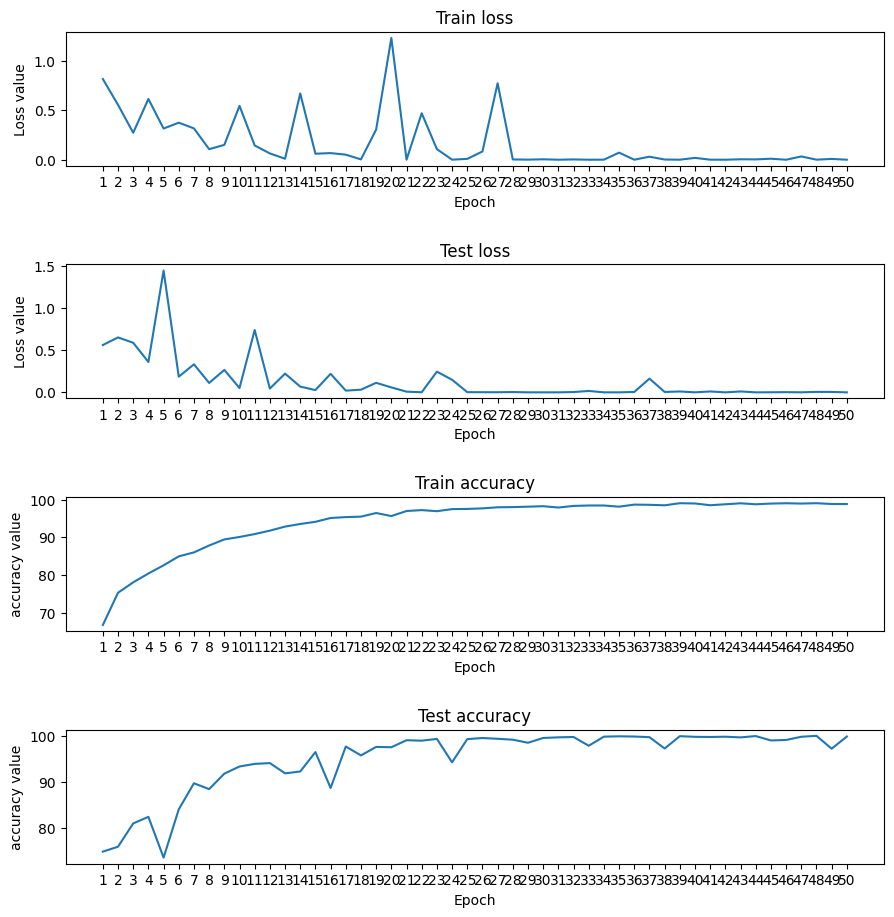

In [24]:
fig, ax = plt.subplots(4, figsize=(10, 10))
fig.tight_layout(pad=5.0)
plt.setp(ax, xticks=[i for i in range(NUM_EPOCHS)], xticklabels=[i+1 for i in range(NUM_EPOCHS)])

ax[0].plot(train_loss_history, label="Train loss")
ax[0].set_title("Train loss")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss value")

ax[1].plot(test_loss_history, label="Test loss")
ax[1].set_title("Test loss")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Loss value")


ax[2].plot(train_accuracy_history, label="Train accuracy")
ax[2].set_title("Train accuracy")
ax[2].set_xlabel("Epoch")
ax[2].set_ylabel("accuracy value")

ax[3].plot(test_accuracy_history, label="Test accuracy")
ax[3].set_title("Test accuracy")
ax[3].set_xlabel("Epoch")
ax[3].set_ylabel("accuracy value")

plt.show()

**Saving**

In [25]:
model_scripted = torch.jit.script(model) # It also saves model class unlike the load_state_dict
model_scripted.save(MODEL_PATH)

**Testing model**

In [26]:
model.eval()

CNNModel(
  (conv0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn0): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc0): Linear(in_features=25088, out_features=64, bias=True)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Line

In [27]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(2)]
    n_class_samples = [0 for i in range(2)]

    for index, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        predicted = outputs.round()

        n_samples += labels.size(0)
        n_correct += (predicted.squeeze() == labels).sum().item()

        if labels.size(0) == BATCH_SIZE:
            for i in range(BATCH_SIZE):
                label = labels[i]
                pred = predicted[i]

                if label == pred:
                    n_class_correct[label] += 1
                n_class_samples[label] += 1


    acc = 100 * n_correct / n_samples
    print(acc)

    for i in range(2):
      acc = 100.0 * n_class_correct[i] / n_class_samples[i]
      print(f'Accuracy of {CLASSES[i]}: {acc} %')

84.47849728126545
Accuracy of cat: 82.49258160237389 %
Accuracy of dog: 86.3681592039801 %


In [28]:
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.Resize((224, 224))
])

In [33]:
images = glob.glob(r"/content/test_set/test_set/cats/*.jpg")
# images = glob.glob(r"/content/test_set/test_set/dogs/*.jpg")
correct = 0

with torch.no_grad():
  for img_path in images:
      with Image.open(img_path) as im:
        custom_image_transformed = data_transforms(im)

      custom_image_transformed_with_batch_size = custom_image_transformed.unsqueeze(dim=0)

      custom_image_transformed = custom_image_transformed.unsqueeze(dim=0)
      custom_image_transformed = custom_image_transformed.to(device)

      custom_image_pred = model(custom_image_transformed)
      if custom_image_pred.round().int().item() == 0:  # 0 for cats and 1 for dogs
        correct += 1

print(f"{correct}/{len(images)}")

742/1011


**Making Predictions after loading model**

In [30]:
model = torch.jit.load(MODEL_PATH)  # when using cpu add map_location=torch.device('cpu')
model.eval()

RecursiveScriptModule(
  original_name=CNNModel
  (conv0): RecursiveScriptModule(original_name=Conv2d)
  (bn0): RecursiveScriptModule(original_name=BatchNorm2d)
  (maxpool): RecursiveScriptModule(original_name=MaxPool2d)
  (conv1): RecursiveScriptModule(original_name=Conv2d)
  (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
  (conv2): RecursiveScriptModule(original_name=Conv2d)
  (bn2): RecursiveScriptModule(original_name=BatchNorm2d)
  (conv3): RecursiveScriptModule(original_name=Conv2d)
  (bn3): RecursiveScriptModule(original_name=BatchNorm2d)
  (dropout): RecursiveScriptModule(original_name=Dropout)
  (fc0): RecursiveScriptModule(original_name=Linear)
  (fc1): RecursiveScriptModule(original_name=Linear)
  (fc2): RecursiveScriptModule(original_name=Linear)
)

In [31]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(2)]
    n_class_samples = [0 for i in range(2)]

    for index, (images, labels) in enumerate(test_loader):
        images = images.to(torch.device('cuda'))
        labels = labels.to(torch.device('cuda'))

        outputs = model(images)
        predicted = outputs.round()

        n_samples += labels.size(0)
        n_correct += (predicted.squeeze() == labels).sum().item()

        if labels.size(0) == BATCH_SIZE:
            for i in range(BATCH_SIZE):
                label = labels[i]
                pred = predicted[i]

                if label == pred:
                    n_class_correct[label] += 1
                n_class_samples[label] += 1


    acc = 100 * n_correct / n_samples
    print(acc)

    for i in range(2):
      acc = 100.0 * n_class_correct[i] / n_class_samples[i]
      print(f'Accuracy of {CLASSES[i]}: {acc} %')

84.47849728126545
Accuracy of cat: 82.49258160237389 %
Accuracy of dog: 86.3681592039801 %


In [32]:
images = glob.glob(r"/content/test_set/test_set/cats/*.jpg")
# images = glob.glob(r"/content/test_set/test_set/dogs/*.jpg")
correct = 0

with torch.no_grad():
  for img_path in images:
      with Image.open(img_path) as im:
        custom_image_transformed = data_transforms(im)

      custom_image_transformed_with_batch_size = custom_image_transformed.unsqueeze(dim=0)

      custom_image_transformed = custom_image_transformed.unsqueeze(dim=0)
      custom_image_transformed = custom_image_transformed.to(device)

      custom_image_pred = model(custom_image_transformed)
      if custom_image_pred.round().int().item() == 0:  # 0 for cats and 1 for dogs
        correct += 1

print(f"{correct}/{len(images)}")

742/1011
